# Processing digital elevation data for deep learning models using Keras Spatial 

Aiman Soliman, Jeffrey Terstriep \
NCSA, University of Illinois Urbana, Illinois

 

## 1. How to Avoid adhoc preprocessing with KS

- background problem adhoc preprocessing 
- introduce our solution (purpose of this notebook)
- what the readers going to learn from this notebook (objectives)

## 2. What is Keras Spatial?

In [1]:
# rational behind keras spatial 
# why keras?
# KS design 
# introduce the different components 


In [2]:
import fiona
import shapely 
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 2.1 Spatial Data Generator

If you are familiar with the deep learning framework Keras, then the SpatialDataGenerator (SDG) resambles the standard Keras ImageDataGenerator class [1 F. Chollet. 2016]. The main difference is that SDG extracts sample data from a single large raster file. This setting is more convenient for remote sensing applications, where the dimensions of an input image file are not equal to the dimensions of a single sample. For example you will find often that a raster file dimiensions are far bigger than the sample dimensions that you want to feed to a deep learning model. In other words a single raster file is likely to contian a large number of samples.

It should be also mentioned that the SDG class does not inharite the flow and flow_from_directory methods provided by the standard ImageDataGenerator to acount for the preprocessing steps that are needed for extracting multiple samples from a single raster. 

In [3]:
from keras_spatial.datagen import SpatialDataGenerator

raster_path = '/home/kv64/main/projects/proj_keras_spatial/data/cl1.tif'
    
sdg = SpatialDataGenerator() 
sdg.source = raster_path

Notice that creating an SDG instance requires a raster data source and an array size. The raster source can be specified as an argument to the SDG initialization or as an attribute. The raster is opened immediately and the raster metadata (band count, CRS, pixel resolution, etc.) is available using the SDG src attribute. If the raster contains multiple bands, all bands are read by default. The indexes attribute can be set to specify the desired bands. 

The array size should match that of the model receptive layer. It is set using the width and height attributes on the SDG instance or as arguments to the flow_from_dataframe with flow_from_dataframe arguments taking precedence. The SDG supports standard interpolation methods (nearest neighbor, bilinear, cubic, etc) to handle resampling from sample size to array size. 

The SDG leverages a warped virtual raster class from Python’s excellent Rasterio package [gillies2013rasterio] which provides access to any raster format supported by the GDAL library, access to local raster and remote rasters over HTTP, and automatic reprojection and resampling to ensure data is registered spatially regardless the original raster projection and pixel resolution.



### 2.2 Sample Generator Utilities

The Keras Spatial grid module provides two functions for generating GeoDataFrames that define the sample boundaries, regular_grid, and random_grid. Both require the spatial extent of the study area, the sample size in coordinate system units and the coordinate reference system (CRS). The regular_grid may also include an overlap that increases the number of samples available to model.

The SDG class includes methods that provide a shortcut in accessing these functions where the spatial extent and CRS are determined directly from the raster source. In this case, the sample width and height are specified in pixels and the sample size is automatically determined by multiplying the raster resolution. Regardless of the method used to create the geodataframe, the sample boundaries are specified in spatial coordinates and are unrelated to the final array size that will be passed to the model.


Created 323 samples


,geometry
0,"POLYGON ((806795 1375599.99, 806795 1380599.99..."
1,"POLYGON ((811957.2222222222 1375599.99, 811957..."
2,"POLYGON ((817119.4444444445 1375599.99, 817119..."
3,"POLYGON ((822281.6666666666 1375599.99, 822281..."
4,"POLYGON ((827443.8888888889 1375599.99, 827443..."


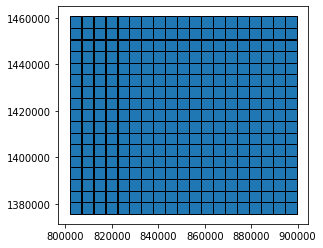

In [10]:
df = sdg.regular_grid(5000, 5000)
print(f'Created {len(df)} samples')

df.plot(color=None, edgecolor='k')
df.head()

Similalry, you could create a dataframe with random samples. In this case you will need to speciy the number of samples in addition to the width and height dimensions of each sample in the native resolution of the SDG source raster. For example, here we created 323 samples as in the regular grid with equal dimnsions of 5000 meters.  

Created 323 samples


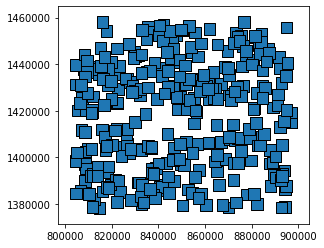

In [5]:
df = sdg.random_grid(5000, 5000, 323)

print(f'Created {len(df)} samples')
df.plot(color=None, edgecolor='k')


### 2.3 Callback Functions 

In [6]:
# explain and give a generic example?

## 3. A practical example: Preprocessing DEM 

In [7]:
# examples to demonstrate the flexiable design of KS

### 3.1 managing sample space 

The GeoDataFrame can also be used to perform sample filtering and determining the global attributes of the sample set. For the former, the study area may be an irregular boundary within the spatial extent. The Keras Spatial grid module contains a mask function to remove samples outside the study area based on an arbitrary polygonal boundary. 

As an example of the latter, the maximum value across all the samples may be required to normalize samples to a known range. Using the SDG, each sample is extracted, it’s maximumly calculated and stored in a column of the GeoDataFrame. Later, the column is used to determine the maximum across all samples. An example of this technique is shown in section 4, where the sample set min/max is passed to a normalization callback.

#### Selecting samples within an area of interest

We will use a vector shapfile as a mask and select only the samples the falls within a particulary watershed. Notice that you could use a more complicated topological relationship for selection, such as selecting samples that intersect, touch, or do not intersect with the boundaries of a vector object. 

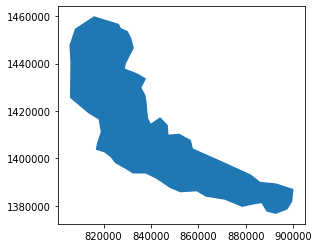

In [8]:
#Read and plot a vector mask 

file = '/home/kv64/main/projects/proj_keras_spatial/data/lake_watershed/lakeb_watershed.shp'
mask = gpd.read_file(file)
mask.plot()

Here we select all the samples that intersects our watershed. Notice that the first and only object (watershed) was selected to perform the intersection process.  

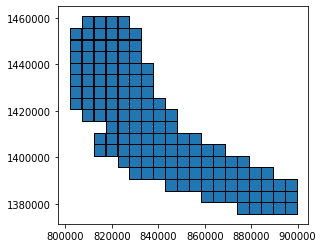

In [11]:
polygon = mask.geometry[0] # define which polygon you want 0 is the first and only polygon
subset = df[df.intersects(polygon)] 
subset.plot(color=None, edgecolor='k')

#### Adding samples' attributes from a raster data

Add text ......

selecting samples with specific attributes (e.g., number of features pixels)  
selecting samples within a watershed 

,geometry,features,elevation
14,"POLYGON ((879066.1111111111 1375599.99, 879066...",0.0,941.049988
15,"POLYGON ((884228.3333333334 1375599.99, 884228...",0.0,887.140015
16,"POLYGON ((889390.5555555555 1375599.99, 889390...",16.0,919.309998
17,"POLYGON ((894552.7777777778 1375599.99, 894552...",222.0,918.400024
18,"POLYGON ((899715 1375599.99, 899715 1380599.99...",72.0,919.729980


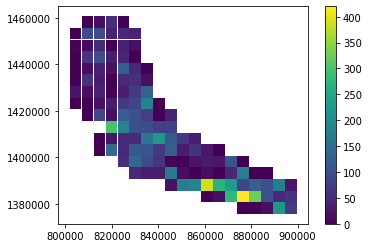

In [27]:
# define label raster as a source raster 
label_path = '/home/kv64/main/projects/proj_keras_spatial/data/cl1.tif'
    
lsdg = SpatialDataGenerator() 
lsdg.source = label_path
input_size = (128,128)

subset.loc[:,'features'] = [ ( np.sum(np.where(arr==1, 0, arr) )) 
                    for arr in lsdg.flow_from_dataframe (subset , *input_size, batch_size =1)]


subset.plot(column='features', legend=True)

subset.head(5)


another example for adding samples attributes from a raster elevation 

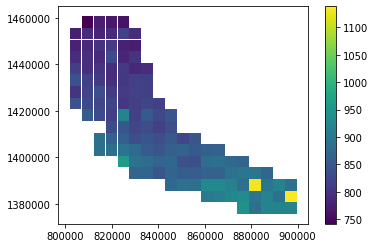

In [30]:
dem_path = '/home/kv64/main/projects/proj_nrcs/original_dem_images/mclean_roi.tif'
rsdg = SpatialDataGenerator(dem_path)

subset.loc[:,'elevation'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (subset, 128, 128, batch_size=1)]
subset.head(10)

subset.plot(column='elevation', legend=True)

### 3.3 Estimating global statistics 

In [35]:
print(np.mean(subset['elevation']), (np.std(subset['elevation'])))

849.8805306174538 56.92307272956207


### 3.1 Feeding data directly to a deep learning model 

In [ ]:
# example of Feeding samples to a DL model 

from keras_spatial import SpatialDataGenerator

labels = SpatialDataGenerator()
labels.source = '/path/to/labels.tif'
labels.width, labels.height = 128, 128
df = labels.regular_grid(200,200)

samples = SpatialDataGenerator()
samples.source = 'https://server.com/files/data.tif'
samples.width, samples.height = labels.width, label.height

train_gen = zip(labels.flow_from_dataframe(df), patches.flow_from_dataframe(df))
model(train_gen)

### 3.4 Calculating DEM derivative on the fly  

In [12]:
# Estimating global statistics for sample normalization



another example for adding samples attributes from derivatives 

## 4. Accounting for Samples Bias using Kears Spatial 

In [ ]:
# class imblance and using soil/geomorphology map to understand the 

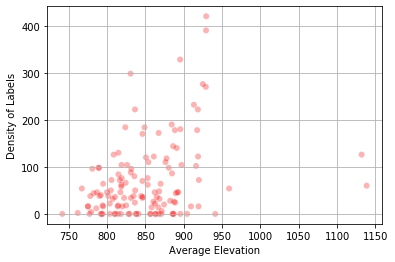

In [37]:
fig, ax = plt.subplots()

x = subset['elevation'].head(10000)
y = subset['features'].head(10000)
#scale = 200.0 * np.random.rand(n)
ax.scatter(x, y, c='red',  alpha=0.3, edgecolors='none')
ax.set_xlabel('Average Elevation')
ax.set_ylabel('Density of Labels')
#ax.legend()
ax.grid(True)

plt.show()

## 5. Conclusions